In [38]:
import sys
import numpy
import matplotlib.pyplot as plt
from astropy.io import fits
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 10})

# Reading and exploring raw files

In [24]:
# Setting path and filenames
path = '/home/mia/Documents/work_UA/Data/test/raw/'
file = 'P13401010041attagfraw.fit'

In [25]:
# Reading the file
hdul = fits.open(path+file)
hdul.info()

Filename: /home/mia/Documents/work_UA/Data/test/raw/P13401010041attagfraw.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  EVENTS        1 BinTableHDU     40   26820R x 4C   [1E, 1I, 1I, 1B]   
  2  GTI           1 BinTableHDU     22   1R x 2C   [1D, 1D]   


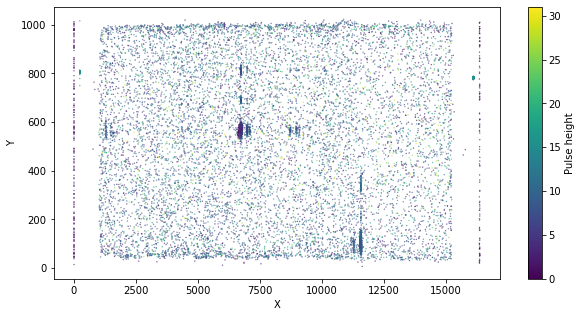

In [40]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['X'], dat['Y'], s=0.1, c=dat['PHA'])
cbar = plt.colorbar(plot)
cbar.set_label('Pulse height')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()

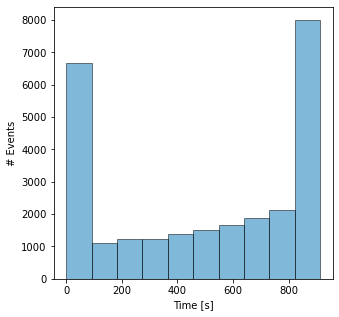

In [49]:
# Plotting histogram of photon events as a function of time

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist(dat['Time'], edgecolor='black', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('# Events')
plt.show()